In [4]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

In [9]:
import os

root_path = os.getcwd()
puds = gpd.read_file(root_path+'/input/Planned_Unit_Development_(PUDs).shp', crs = {'init' :'epsg:4326'})
aff = pd.read_csv(root_path+'/input/Affordable_Housing.csv')
crosswalk = pd.read_csv(root_path+'/input/zoning_crosswalk.csv')

In [24]:
puds.info()
puds.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    302 non-null    int64   
 1   PUD_NAME    302 non-null    object  
 2   PUD_WEB_UR  302 non-null    object  
 3   PUD_CHANGE  300 non-null    object  
 4   PUD_ZONING  302 non-null    object  
 5   PUD_STATUS  302 non-null    object  
 6   PUD_CASE_N  302 non-null    object  
 7   GLOBALID    302 non-null    object  
 8   WARD        301 non-null    object  
 9   SHAPEAREA   302 non-null    int64   
 10  SHAPELEN    302 non-null    int64   
 11  geometry    302 non-null    geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 28.4+ KB


,OBJECTID,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,SHAPELEN,geometry
155,176211,Fifth and Morse L/Cal LLC,https://app.dcoz.dc.gov/Content/Search/ViewCas...,"Setdown 6/13/16, DC Register 12/8/17",C-3-C,Final,16-05,{9A309640-9347-4ADA-B826-5B93A366752C},Ward 5,0,0,"POLYGON ((-76.99851 38.90779, -76.99806 38.907..."


In [25]:
aff.info()
aff.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 557 entries, 0 to 556
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   X                              557 non-null    float64 
 1   Y                              557 non-null    float64 
 2   OBJECTID                       557 non-null    int64   
 3   MAR_WARD                       557 non-null    object  
 4   ADDRESS                        554 non-null    object  
 5   PROJECT_NAME                   557 non-null    object  
 6   STATUS_PUBLIC                  557 non-null    object  
 7   AGENCY_CALCULATED              557 non-null    object  
 8   TOTAL_AFFORDABLE_UNITS         557 non-null    int64   
 9   LATITUDE                       554 non-null    float64 
 10  LONGITUDE                      554 non-null    float64 
 11  AFFORDABLE_UNITS_AT_0_30_AMI   557 non-null    int64   
 12  AFFORDABLE_UNITS_AT_31_50_AM

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
397,-77.015616,38.87676,1167,Ward 6,"301 M Street Southwest, Washington, District o...",301 M,Completed 2015 to Date,DHCD OP,15,38.876752,...,0,15,0,12-14/12-14A,312585.0,398645.17,134324.71,301 M STREET SW,2021/03/22 04:01:12+00,POINT (-77.01562 38.87676)


In [26]:
crosswalk.info()
crosswalk.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Zone      64 non-null     object
 1   Count     64 non-null     int64 
 2   Zone_Cat  64 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,Zone,Count,Zone_Cat
47,R-1-A,1,Residential


In [27]:
# Create a geometry column in the affordable housing dataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1)
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'})

In [28]:
# Use geospatial join to identify which PUDs include affordable housing projects
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

In [29]:
puds_aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 301
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  310 non-null    int64   
 1   PUD_NAME                       310 non-null    object  
 2   PUD_WEB_UR                     310 non-null    object  
 3   PUD_CHANGE                     308 non-null    object  
 4   PUD_ZONING                     310 non-null    object  
 5   PUD_STATUS                     310 non-null    object  
 6   PUD_CASE_N                     310 non-null    object  
 7   GLOBALID                       310 non-null    object  
 8   WARD                           309 non-null    object  
 9   SHAPEAREA                      310 non-null    int64   
 10  SHAPELEN                       310 non-null    int64   
 11  geometry                       310 non-null    geometry
 12  index_right                 

In [39]:
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])
puds_info.info()
puds_info.sample()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 310 entries, 0 to 309
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  310 non-null    int64   
 1   PUD_NAME                       310 non-null    object  
 2   PUD_WEB_UR                     310 non-null    object  
 3   PUD_CHANGE                     308 non-null    object  
 4   PUD_ZONING                     310 non-null    object  
 5   PUD_STATUS                     310 non-null    object  
 6   PUD_CASE_N                     310 non-null    object  
 7   GLOBALID                       310 non-null    object  
 8   WARD                           309 non-null    object  
 9   SHAPEAREA                      310 non-null    int64   
 10  SHAPELEN                       310 non-null    int64   
 11  geometry                       310 non-null    geometry
 12  index_right                 

,OBJECTID_left,PUD_NAME,PUD_WEB_UR,PUD_CHANGE,PUD_ZONING,PUD_STATUS,PUD_CASE_N,GLOBALID,WARD,SHAPEAREA,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,Zone_Cat
156,176207,DC Stadium LLC,https://app.dcoz.dc.gov/Content/Search/ViewCas...,Setdown 3/14/16,None,Final,16-02,{B3C5C39C-02E8-41E8-BF16-D9DCDC6F5772},Ward 6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other/Mixed Use


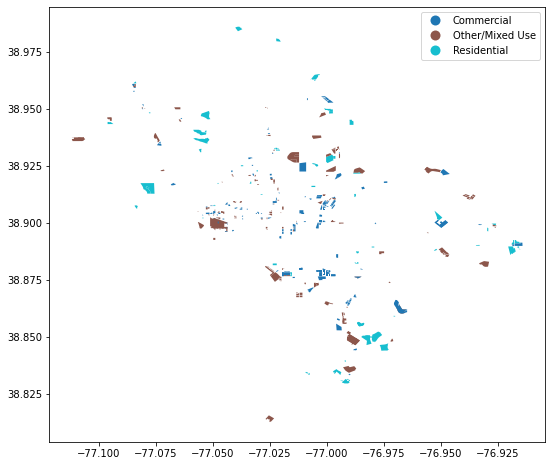

In [53]:
# Create a map of PUDs by Zoning Category
# remove the NaN
puds_info = puds_info[~puds_info['Zone_Cat'].isnull()]
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));

/Users/michaelzhao/opt/anaconda3/envs/geo/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


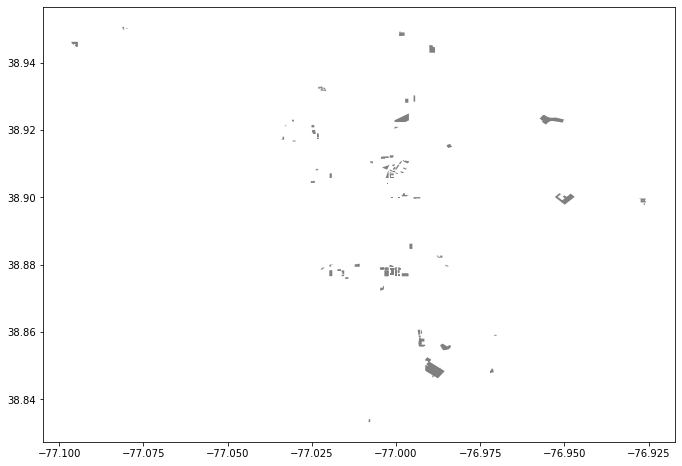

In [56]:
# Create a map of just the PUDs that provide Affordable Housing
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS',color='grey', figsize=(16,8));